Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2240
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds  = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',  # Automatically infer class labels from directory names
    label_mode='int',   # Options: 'int', 'categorical', or None
    image_size=(img_height, img_width),  # Resize all images to this size
    batch_size=batch_size,  # Number of images per batch
    shuffle=True,   # Shuffle the dataset
    seed=123,        # Random seed for reproducibility
    validation_split = 0.2,
    subset = 'training'
)

Found 2240 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    shuffle=False,  # Typically, no shuffle for validation/test datasets
)

Found 2240 files belonging to 9 classes.
Using 448 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

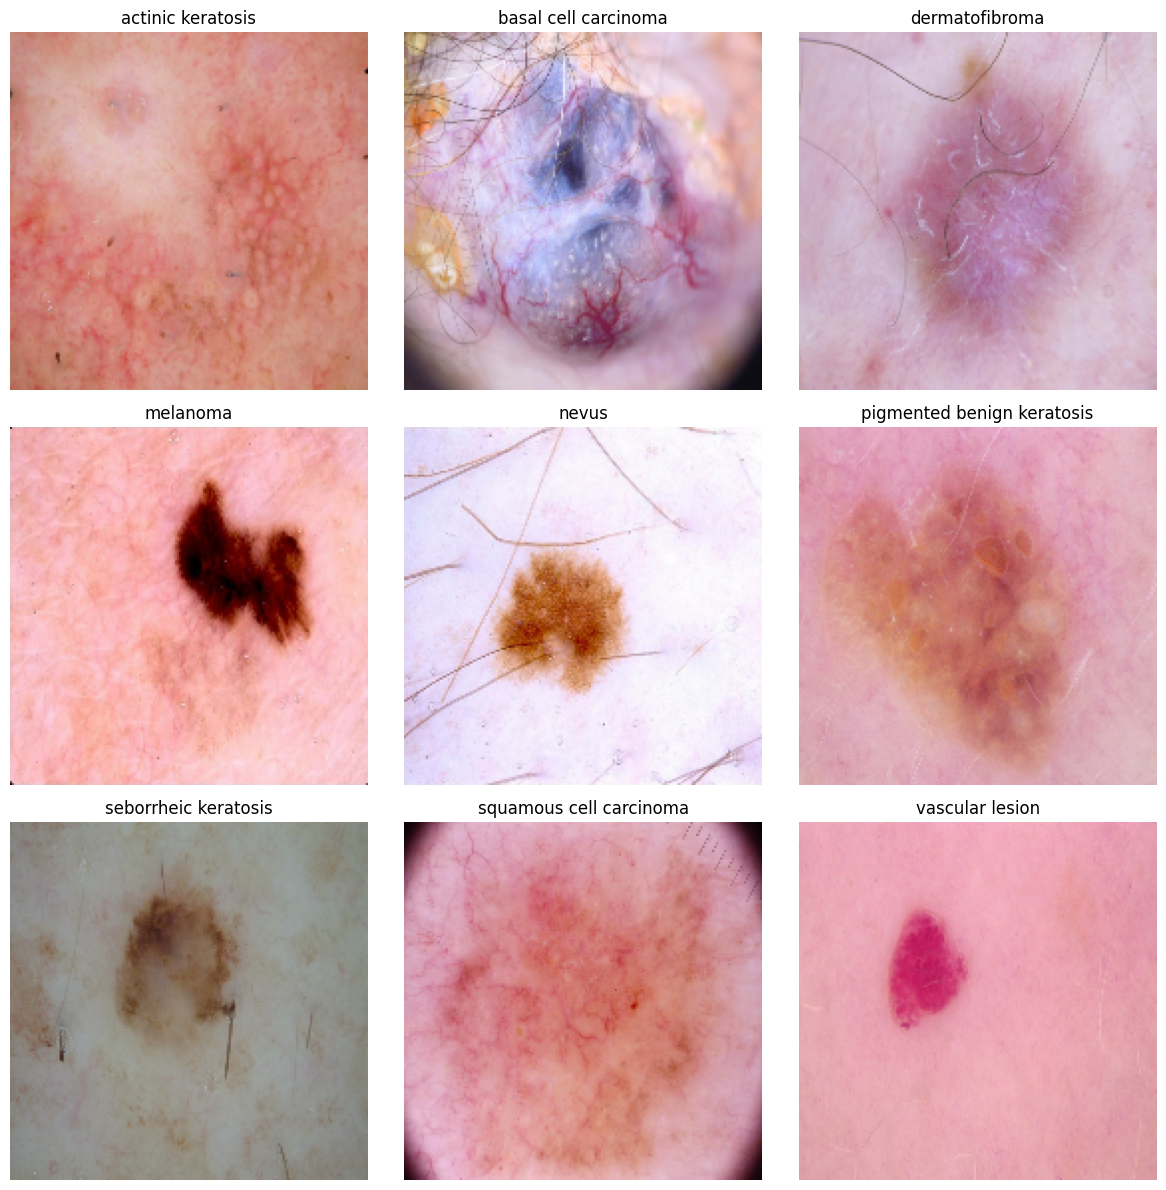

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

#class_names = train_ds.class_names
# Initialize a dictionary to store one image per class
class_images = {class_name: None for class_name in class_names}

for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_images[class_name] is None:
            class_images[class_name] = img
        # Stop once we have one image for each class
        if all(value is not None for value in class_images.values()):
            break
    if all(value is not None for value in class_images.values()):
        break

# Plot one image for each class
plt.figure(figsize=(12, 12))
for i, (class_name, img) in enumerate(class_images.items()):
    ax = plt.subplot(3, 3, i + 1)  # Create a grid for 9 classes
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Experiment 1 : Adding 2 Conv2D layer, Flattening Layer,1 FC layer and adding dropput (0.5) after the FC layer

In [ ]:
### Your code goes here

model = models.Sequential([
        # Rescaling Layer
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),


        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flattening Layer
        layers.Flatten(),

        # Fully Connected Dense Layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,167,691 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.4647 - loss: 1.4725 - val_accuracy: 0.2299 - val_loss: 2.1807
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5049 - loss: 1.4187 - val_accuracy: 0.3616 - val_loss: 1.8242
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5218 - loss: 1.3905 - val_accuracy: 0.3415 - val_loss: 1.6584
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.5190 - loss: 1.3609 - val_accuracy: 0.2723 - val_loss: 1.7343
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.5355 - loss: 1.2929 - val_accuracy: 0.2656 - val_loss: 1.8655
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5366 - loss: 1.3170 - val_accuracy: 0.3237 - val_loss: 1.5027
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5593 - loss: 1.2532 - val_accuracy: 0.3237 - val_loss: 1.6948
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5634 - loss: 1.2781 - val_accuracy: 0.2879 - v

### Visualizing training results

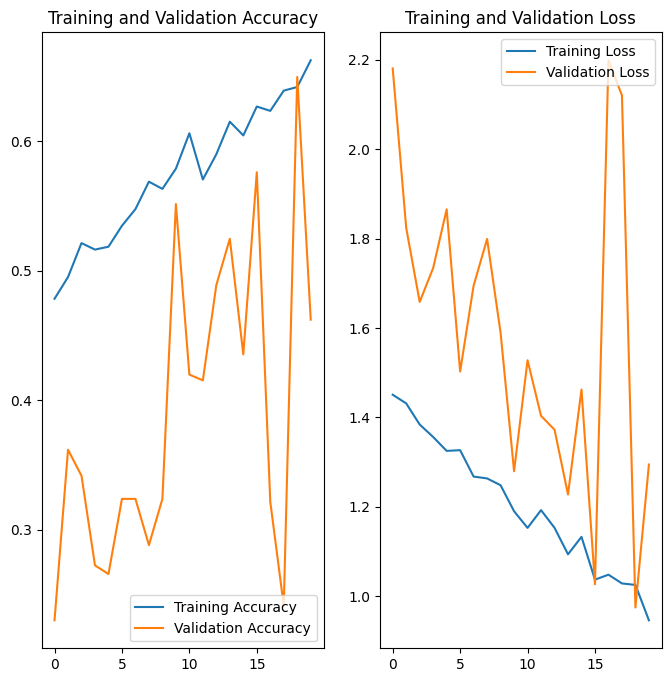

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit




### Write your findings here

### **Experiment 1 : Drop Out after 2 Convolution Layer 1 FC Layer**

**1)Overfitting**

Validation accuracy drops and validation loss increases after Epoch 19, despite improving training metrics.
The model is becoming too specialized to the training data, losing generalization ability.

**2)Early Improvements**

Validation accuracy improves significantly up to Epoch 10 (55.13%), showing that the model was effectively learning patterns initially.
Sudden Drops in Validation Performance (Epochs 17-18):

**3)Validation Loss Spikes**

Large losses (2.1990 and 2.1205) indicate the model struggled during these epochs.


### Experiment 2

Running the second experiment to add drop out of 0.25 after each Con2D layer

### Create the Model

In [ ]:
### Your code goes here

model = models.Sequential([
        # Rescaling Layer
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),  # Dropout for regularization

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),  # Dropout for regularization

        # Flattening Layer
        layers.Flatten(),

        # Fully Connected Dense Layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

###Compile the Model

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.1872 - loss: 2.1740 - val_accuracy: 0.1138 - val_loss: 2.3200
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.2138 - loss: 2.0566 - val_accuracy: 0.0737 - val_loss: 2.2813
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2584 - loss: 2.0105 - val_accuracy: 0.0670 - val_loss: 2.3764
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2846 - loss: 1.9862 - val_accuracy: 0.0089 - val_loss: 2.5244
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.2690 - loss: 1.9614 - val_accuracy: 0.1116 - val_loss: 2.2611
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2928 - loss: 1.9361 - val_accuracy: 0.1071 - val_loss: 2.2585
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3273 - loss: 1.8720 - val_accuracy: 0.0804 - val_loss: 2.2144
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3221 - loss: 1.8890 - val_accuracy: 0.0737 - v

### Visualise training  results

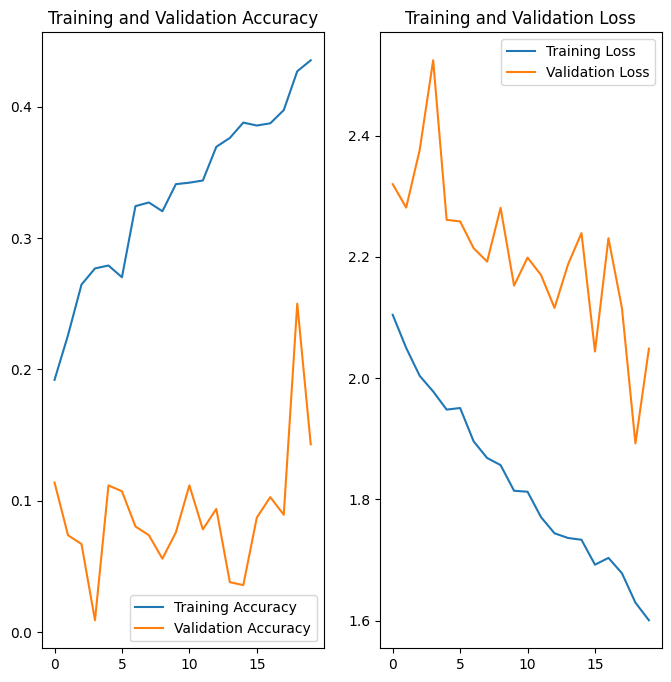

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Finding of Experiment 2 : Running the second experiment to add drop out of 0.25 after each Con2D layer

**Poor Generalization:**

Validation accuracy lags significantly behind training accuracy.
Validation loss does not improve substantially, and there's no clear indication of the model adapting to the validation data.

**Slow Learning Progress:**

Both training and validation accuracies improve very slowly.

**Overfitting:**

The gap between training and validation performance suggests overfitting to the training data, especially by the later epochs.




### Experiment 3 : Remove the dropouts after the convolutional layers (but retain them in the FC layer). Also, use batch normalization after every convolutional layer.

Create the Model

In [ ]:
### Your code goes here

model = models.Sequential([
        # Rescaling Layer
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),  # Batch Normalization
        layers.MaxPooling2D((2, 2)),


        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),  # Batch Normalization
        layers.MaxPooling2D((2, 2)),


        # Flattening Layer
        layers.Flatten(),

        # Fully Connected Dense Layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

Compile the model

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,168,073 (57.86 MB)

 Trainable params: 15,167,881 (57.86 MB)

 Non-trainable params: 192 (768.00 B)

Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.1947 - loss: 9.9553 - val_accuracy: 0.2679 - val_loss: 2.2334
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.2897 - loss: 2.1138 - val_accuracy: 0.0625 - val_loss: 2.1221
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.3659 - loss: 1.8852 - val_accuracy: 0.0179 - val_loss: 2.1807
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.3923 - loss: 1.7809 - val_accuracy: 0.0938 - val_loss: 2.2161
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.4035 - loss: 1.7803 - val_accuracy: 0.0938 - val_loss: 2.2286
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.4253 - loss: 1.5500 - val_accuracy: 0.0357 - val_loss: 2.4833
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.4722 - loss: 1.5113 - val_accuracy: 0.3326 - val_loss: 1.8363
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.5051 - loss: 1.4010 - val_accuracy: 0.3929 - v

Visualise the results

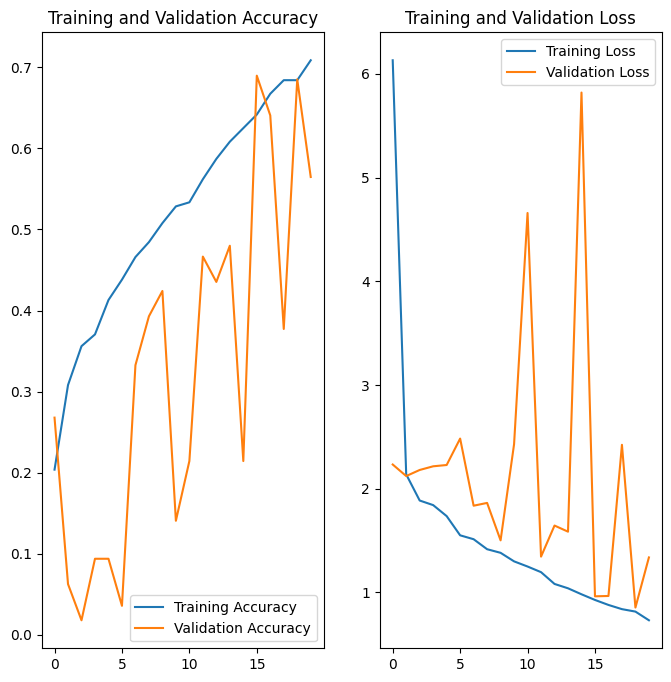

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Finding of Experiment 3 :Remove the dropouts after the convolutional layers (but retain them in the FC layer). Also, use batch normalization after every convolutional layer.**

**Initial Struggles (Epochs 1-6):**

Training loss is very high (9.9553) in the first epoch, indicating either initialization issues or a challenging dataset.
Validation accuracy fluctuates and remains low during this period.

**Midpoint Stabilization (Epochs 7-16):**

Training and validation metrics improve steadily.
Validation accuracy peaks at 68.97% (Epoch 16), suggesting the model performs well on the validation set during this period.

**Instability in Late Epochs:**

Large validation loss spikes in Epochs 15 (5.8189) and 18 (2.4233), followed by recovery in Epoch 19 (0.8544).
Indicates overfitting or sensitivity to specific batches.

**Overfitting Signs:**

By the end, training accuracy is higher (70.58%) compared to validation accuracy (56.47%).
Validation loss begins to increase after reaching a low point in Epoch 19.

### **Augmentation Strategy**

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

# Define the augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip images
    layers.RandomRotation(0.2),  # Rotate images randomly
    layers.RandomZoom(0.2),  # Zoom in or out randomly
    layers.RandomContrast(0.1),  # Adjust image contrast randomly
])



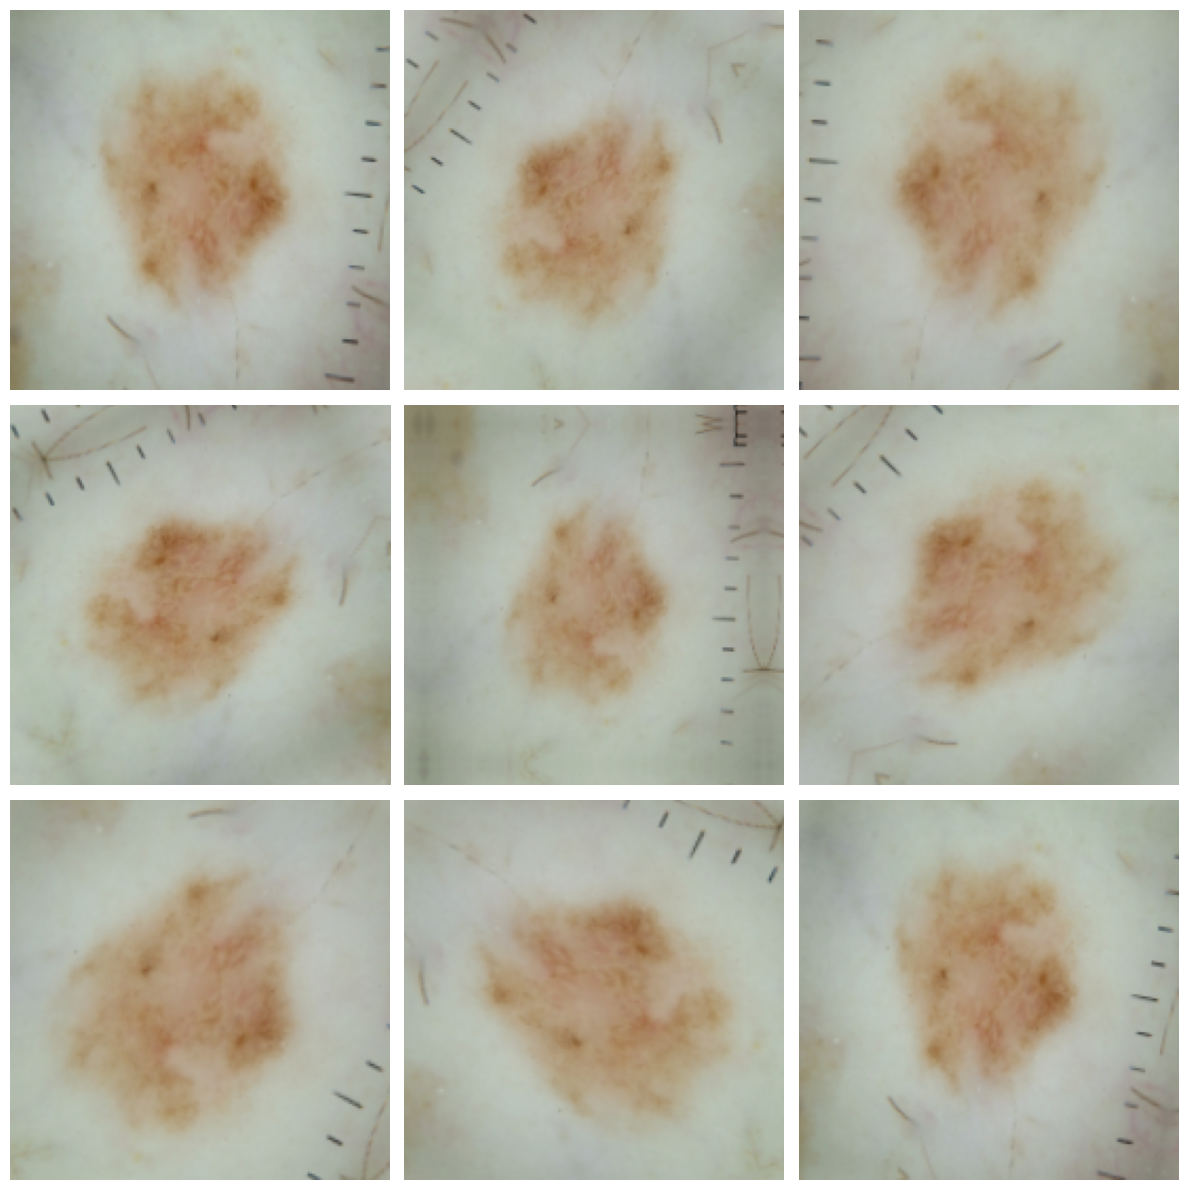

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Visualize augmented images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for images, _ in train_ds.take(1):  # Take one batch of training data
    for i in range(9):  # Display 9 augmented images
        augmented_image = data_augmentation(images[0:1])  # Apply augmentation
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))  # Convert tensor to image
        plt.axis("off")

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    # Data Augmentation Layer
    data_augmentation,

    # Rescaling Layer
    layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flattening Layer
    layers.Flatten(),

    # Fully Connected Dense Layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation='softmax'),
])



### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1, 178, 178, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (1, 178, 178, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (1, 89, 89, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (1, 87, 87, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (1, 87, 87, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (1, 43, 43, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (1, 41, 41, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (1, 41, 41, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (1, 20, 20, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 51200)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 256)                    │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 9)                      │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,203,913 (50.37 MB)

 Trainable params: 13,203,465 (50.37 MB)

 Non-trainable params: 448 (1.75 KB)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.2930 - loss: 16.2481 - val_accuracy: 0.0000e+00 - val_loss: 24.4315
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.3335 - loss: 5.2373 - val_accuracy: 0.0000e+00 - val_loss: 27.5993
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - accuracy: 0.3554 - loss: 2.7493 - val_accuracy: 0.0000e+00 - val_loss: 15.9840
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 382ms/step - accuracy: 0.3773 - loss: 2.0730 - val_accuracy: 0.0000e+00 - val_loss: 14.3810
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - accuracy: 0.4141 - loss: 1.9621 - val_accuracy: 0.3036 - val_loss: 7.8426
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.4309 - loss: 1.7722 - val_accuracy: 0.4152 - val_loss: 3.1262
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - accuracy: 0.4294 - loss: 1.6616 - val_accuracy: 0.2321 - val_loss: 2.9740
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 370ms/step - accuracy: 0.4653 - lo

### Visualizing the results

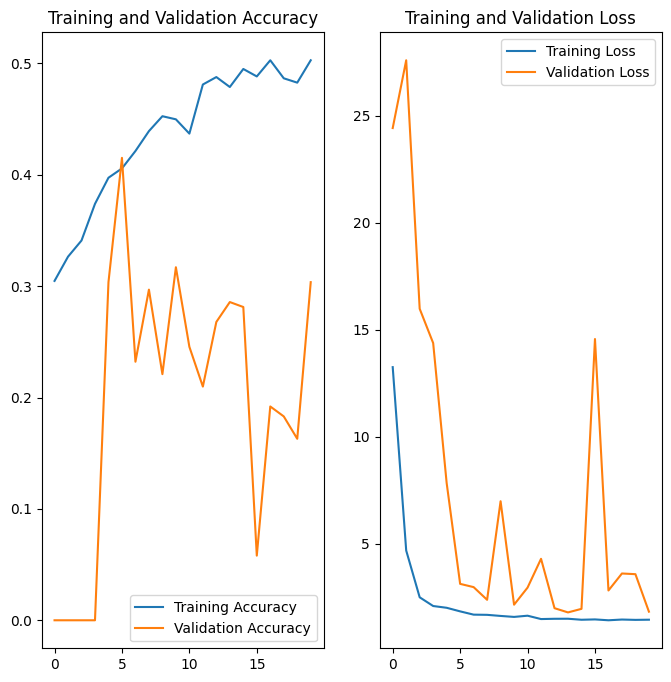

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

###Findings of the results####


**Training Accuracy:**

Training accuracy increases slightly (to ~52.37%), but it's still low.
Indicates the model is learning, but its capacity may not be sufficient for the dataset's complexity.

**Validation Performance:**

High validation loss suggests overfitting or insufficient generalization.
Low validation accuracy (around 30%) shows the model struggles with unseen data.

**Signs of Overfitting:**

Training loss decreases steadily, but validation loss remains erratic.
Validation accuracy does not consistently improve, suggesting overfitting or data imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class Distribution in Training Dataset:
seborrheic keratosis: 59
melanoma: 353
actinic keratosis: 91
squamous cell carcinoma: 144
basal cell carcinoma: 309
vascular lesion: 112
dermatofibroma: 77
nevus: 277
pigmented benign keratosis: 370


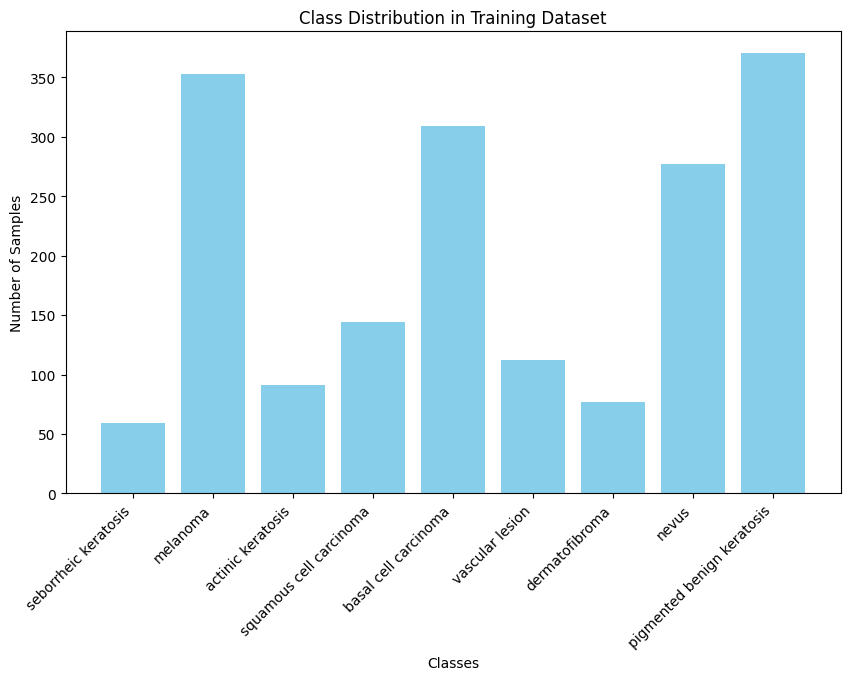

In [ ]:
## Your code goes here.

from collections import Counter
#import matplotlib.pyplot as plt

# Extract labels from the training dataset
labels = []
for _, batch_labels in train_ds.unbatch():  # Unbatch to access individual labels
    labels.append(batch_labels.numpy())

# Count occurrences of each class
label_counts = Counter(labels)

# Map counts to class names
class_distribution = {class_names[class_id]: count for class_id, count in label_counts.items()}

# Print class distribution
print("Class Distribution in Training Dataset:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count}")

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.show()


#### **Todo:** Write your findings here:

#### - Which class has the least number of samples?
## seborrheic keratosis has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
## pigmented benign keratosis: 370,melanoma: 353 and basal cell carcinoma: 309 has highest proportionaate number of samples.

### **Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset = "/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EBF070A230>: 100%|██████████| 500/500 [00:24<00:00, 20.12 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EBF045FBB0>: 100%|██████████| 500/500 [00:21<00:00, 23.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EBFFFC4FD0>: 100%|██████████| 500/500 [00:19<00:00, 25.84 Samples/s]


Initialised with 439 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79EBF079FB20>: 100%|██████████| 500/500 [01:22<00:00,  6.08 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x79EBF04F65C0>: 100%|██████████| 500/500 [01:20<00:00,  6.21 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EC0F0E0700>: 100%|██████████| 500/500 [00:19<00:00, 25.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79EBF04F5750>: 100%|██████████| 500/500 [00:42<00:00, 11.67 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EC0C4BC0A0>: 100%|██████████| 500/500 [00:18<00:00, 26.68 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79EBF079F130>: 100%|██████████| 500/500 [00:20<00:00, 23.86 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new


['/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_74243b2d-0362-46f6-b85c-3ceabfc2f97c.jpg',
 '/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_7aa807dc-3d8b-49d1-b4d6-9bd573027ea4.jpg',
 '/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_acbe5d91-1d50-4298-966f-e3db2a23588a.jpg',
 '/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_1a454a98-4e1c-4a7b-9131-35b986dd502a.jpg',
 '/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboratio

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
original_df = pd.DataFrame(train_ds)
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = "/content/drive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", # Todo choose the correct parameter value, so that only training data is refered to,,
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6740 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6740 files belonging to 9 classes.
Using 1348 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model = Sequential([

    # Data Augmentation Layer
    data_augmentation,
    # Rescaling Layer
    layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flattening Layer
    layers.Flatten(),

    # Fully Connected Dense Layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation='softmax'),
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 273ms/step - accuracy: 0.2507 - loss: 13.2926 - val_accuracy: 0.0972 - val_loss: 19.6126
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 257ms/step - accuracy: 0.2786 - loss: 2.1237 - val_accuracy: 0.1691 - val_loss: 5.1925
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 253ms/step - accuracy: 0.3256 - loss: 1.8703 - val_accuracy: 0.2515 - val_loss: 3.7268
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - accuracy: 0.3229 - loss: 1.7561 - val_accuracy: 0.3598 - val_loss: 2.2402
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - accuracy: 0.3741 - loss: 1.7118 - val_accuracy: 0.3138 - val_loss: 2.1392
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - accuracy: 0.3613 - loss: 1.6475 - val_accuracy: 0.4006 - val_loss: 1.6271
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 262ms/step - accuracy: 0.3859 - loss: 1.6329 - val_accuracy: 0.3872 - val_loss: 1.9639
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.3941 - loss:

#### **Todo:**  Visualize the model results

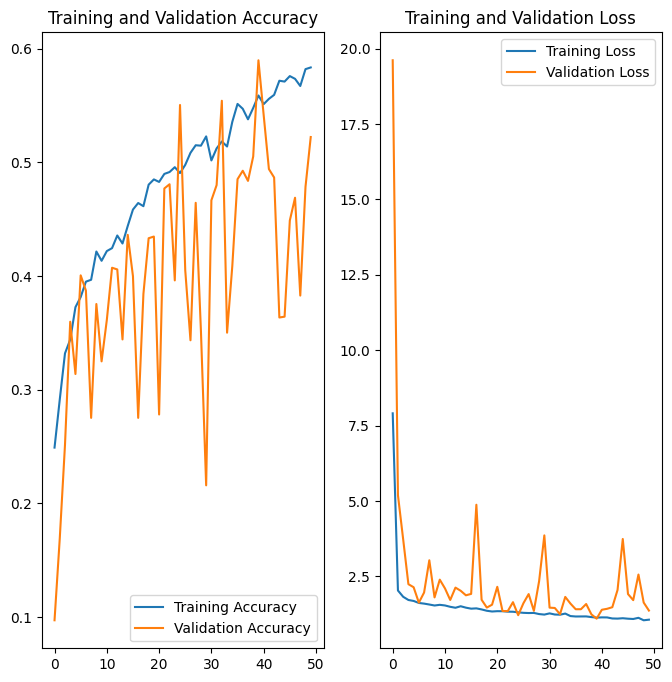

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Training Accuracy:**

Starts very low at ~25% (Epoch 1) and steadily improves to ~57.92% (Epoch 50).
This indicates that the model is learning to recognize patterns in the training dataset but still has a long way to achieve good performance.

**Validation Accuracy:**

Begins low at ~9.72% (Epoch 1) but shows some improvement, ending at ~52.23% (Epoch 50).
There are fluctuations in the middle epochs (e.g., dips around Epochs 8 and 44–48), which could indicate overfitting or instability.

**Loss Behavior:**

The training loss steadily decreases, showing that the model is minimizing the error on the training data.
The validation loss, however, fluctuates and does not always follow the training loss pattern. For example:
Epoch 6: Validation loss is 1.6271 (good).
Epoch 30: Validation loss increases to 3.8588 (poor).

**Class Imbalance**

The results show gradual improvement in training accuracy and a decent final validation accuracy (52.23%),
indicating that class rebalancing had a positive impact.
However:
The overall accuracy (57.92%) suggests that the model is still struggling to differentiate between classes effectively.